# Pretraining BERT the notebook

This accompanies the blog post: [sidsite.com/posts/bert-from-scratch](https://sidsite.com/posts/bert-from-scratch/)

We will:
- Download the [dataset](https://huggingface.co/datasets/sradc/chunked-shuffled-wikipedia20220301en-bookcorpusopen) I prepared in advance
- Train a WordPiece tokenizer on a sample of the data
- Initialize BERT-base-uncased and train it as a masked language model (this is called "pretraining")

My workflow was to debug/develop in this notebook, but to run the longer training as a script:
```
jupyter nbconvert pretraining_BERT.ipynb --to script   \
    && nohup ipython pretraining_BERT.py &
```

Notes:
- The comments mention "Cramming", which refers to [this](https://arxiv.org/abs/2212.14034) paper, from which I got various parameter values.
- The outputs in this notebook are from a dummy run, on only 4 batches. Set `LIMIT_DATASET=None` to run on the full dataset.
- Adjust the batch_size and sequence length based on the VRAM you have available (try to fill up your VRAM, to increase throughput).

In [1]:
%env WANDB_START_METHOD=thread
%env WANDB_PROJECT=pretraining_BERT_the_notebook

env: WANDB_START_METHOD=thread
env: WANDB_PROJECT=pretraining_BERT_the_notebook


In [2]:
import json
from pathlib import Path
from typing import Iterator
import time

import datasets
import matplotlib.pyplot as plt
import pandas as pd
import pynvml
import torch
from magic_timer import MagicTimer
from tokenizers import BertWordPieceTokenizer, Regex, normalizers
from tqdm import tqdm
from transformers import (
    BertConfig,
    BertForMaskedLM,
    BertTokenizerFast,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [3]:
# Print hardware information
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
gpu_name = pynvml.nvmlDeviceGetName(handle)
gpu_mem = pynvml.nvmlDeviceGetMemoryInfo(handle).total / (1024**2)
print(f"GPU: {gpu_name}, {gpu_mem} MiB")
print(f"{torch.cuda.is_available() = }")

GPU: NVIDIA GeForce RTX 3060 Ti, 7981.0 MiB
torch.cuda.is_available() = True


In [4]:
LIMIT_DATASET = 2016 * 4  # keep small for development, set to None for full dataset

RANDOM_SEED = 42
NUM_TOKENIZER_TRAINING_ITEMS = 1_000_000  # I made this up, but it seems reasonable
VOCAB_SIZE = 32_768  # from Cramming
DEVICE_BATCH_SIZE = 36  # adjust to get near 100% gpu memory use
MODEL_MAX_SEQ_LEN = 128  # from Cramming

gradient_accumulation_steps = 2048 // DEVICE_BATCH_SIZE  # roughly based on Cramming
batch_size = DEVICE_BATCH_SIZE * gradient_accumulation_steps
print(f"{DEVICE_BATCH_SIZE = }")
print(f"{gradient_accumulation_steps = }")
print(f"{batch_size = }")

DEVICE_BATCH_SIZE = 36
gradient_accumulation_steps = 56
batch_size = 2016


In [5]:
RUN_DIR = Path("data") / f"run_{time.strftime('%Y%m%d-%H%M%S')}"
CHECKPOINT_DIR = RUN_DIR / "training_checkpoints"
MODEL_DIR = RUN_DIR / "model"
TOKENIZER_PATH = RUN_DIR / "tokenizer.json"
TRAINER_HISTORY_PATH = RUN_DIR / "trainer_history.json"

RUN_DIR.mkdir(exist_ok=True, parents=True)

## Load the dataset for pretraining

The dataset is already split into chunks, and shuffled.

In [7]:
with MagicTimer() as timer:
    dataset = datasets.load_dataset(
        "sradc/chunked-shuffled-wikipedia20220301en-bookcorpusopen",
        split=f"train[:{LIMIT_DATASET}]" if LIMIT_DATASET else "train",
        revision="0e6fada2dd43136e4a3f637da41de2e596aee674",
    )
print(f"Loaded dataset in {timer}")

Found cached dataset parquet (/home/sid/.cache/huggingface/datasets/sradc___parquet/sradc--chunked-shuffled-wikipedia20220301en-bookcorpusopen-ff5cb88917a65ec5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Loaded dataset in 1.4 seconds


## Create tokenizer, with a custom normalizer

In [8]:
tokenizer = BertWordPieceTokenizer()
tokenizer._tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace(Regex("(``|'')"), '"'),
        normalizers.NFD(),
        normalizers.Lowercase(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
        normalizers.Replace(Regex(r"[^\x00-\x7F]+"), ""),
    ]
)  # Normalizer based on, https://github.com/JonasGeiping/cramming/blob/50bd06a65a4cd4a3dd6ee9ecce1809e1a9085374/cramming/data/tokenizer_preparation.py#L52

## Train tokenizer

In [9]:
def tokenizer_training_data() -> Iterator[str]:
    for i in tqdm(
        range(min(NUM_TOKENIZER_TRAINING_ITEMS, len(dataset))),
        desc="Feeding samples to tokenizer",
    ):
        yield dataset[i]["text"]


with MagicTimer() as timer:
    tokenizer.train_from_iterator(
        tokenizer_training_data(),
        vocab_size=VOCAB_SIZE,
        min_frequency=2,
    )
print(f"Tokenizer trained in {timer}.")
tokenizer.save(str(TOKENIZER_PATH))

Feeding samples to tokenizer: 100%|██████████| 8064/8064 [00:00<00:00, 11945.67it/s]





Tokenizer trained in 2.0 seconds.


## Initialize model and fast tokenizer

In [10]:
model_config = BertConfig(
    vocab_size=VOCAB_SIZE,
    max_position_embeddings=MODEL_MAX_SEQ_LEN,
    attention_probs_dropout_prob=0,  # cramming says no dropout
    hidden_dropout_prob=0,  # cramming says no dropout
)
model = BertForMaskedLM(model_config)
tokenizer = BertTokenizerFast(tokenizer_file=str(TOKENIZER_PATH))

## Create TokenizedDataset to feed to model

In [11]:
class TokenizedDataset(torch.utils.data.Dataset):
    "This wraps the dataset and tokenizes it, ready for the model"

    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.tokenizer.encode(
            self.dataset[i]["text"],
            return_tensors="pt",
            truncation=True,
            max_length=MODEL_MAX_SEQ_LEN - 2,
            padding="max_length",
            return_special_tokens_mask=True,
        )[0, ...]


tokenized_dataset = TokenizedDataset(dataset, tokenizer)

## Initialize masked language model data collator

This masks 15% of the tokens in the dataset, as per the original BERT paper.

In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    return_tensors="pt",
)

## Initialize the Trainer

In [13]:
training_args = TrainingArguments(
    # Optimizer values are from Cramming
    learning_rate=1e-3,
    warmup_ratio=0.5,
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-9,
    weight_decay=0.01,
    max_grad_norm=0.5,
    num_train_epochs=1,
    per_device_train_batch_size=DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=gradient_accumulation_steps,
    dataloader_num_workers=4,
    save_steps=60,
    save_total_limit=2,
    logging_steps=1,
    output_dir=CHECKPOINT_DIR,
    optim="adamw_torch",
    report_to="wandb",
)
Trainer._get_train_sampler = lambda _: None  # prevent shuffling the dataset again
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Train the model

In [14]:
# Avoid warning about parallelism. We only needed it for the training above,
# (we have enough time in between batches to tokenize).
%env TOKENIZERS_PARALLELISM=false

with MagicTimer() as timer:
    trainer.train()
print(f"Trained model in {timer}.")
trainer.save_model(str(MODEL_DIR))
TRAINER_HISTORY_PATH.write_text(json.dumps(trainer.state.log_history))

env: TOKENIZERS_PARALLELISM=false


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sradc. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,10.584000
2,10.585500


Trained model in 1.6 minutes.


459

## Plot training loss

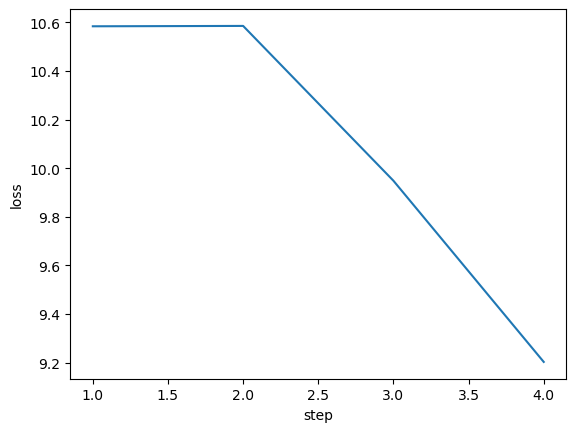

In [15]:
trainer_history = pd.DataFrame(trainer.state.log_history[:-1]).set_index("step")
trainer_history.loss.plot(label="loss")
plt.ylabel("loss")
plt.savefig(RUN_DIR / "loss.png")